# BTC from BNB and ETH

In [1]:
from google.colab import files
uploaded = files.upload()


Saving yahoo_ETH.csv to yahoo_ETH.csv
Saving yahoo_BTC.csv to yahoo_BTC.csv
Saving yahoo_BNB.csv to yahoo_BNB.csv


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from keras.regularizers import l2
from sklearn.metrics import mean_absolute_error, mean_squared_error

C:\Users\Sreelakshmi\AppData\Local\Temp\ipykernel_13404\3203501300.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


# BTC from BNB and ETH - All features

In [2]:
#  Load datasets
btc_data = pd.read_csv('yahoo_BTC.csv')
eth_data = pd.read_csv('yahoo_ETH.csv')
bnb_data = pd.read_csv('yahoo_BNB.csv')

In [4]:
# Convert the Date column to datetime
for df in [btc_data, eth_data, bnb_data]:
    df['Date'] = pd.to_datetime(df['Date'])

#Merging the datasets
merged_data = eth_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
    'Open': 'ETH_Open', 'High': 'ETH_High', 'Low': 'ETH_Low', 'Close': 'ETH_Close', 'Volume': 'ETH_Volume'})
merged_data = merged_data.merge(
    bnb_data[['Date', 'Open', 'High', 'Low', 'Close','Volume']].rename(columns={
        'Open': 'BNB_Open', 'High': 'BNB_High', 'Low': 'BNB_Low', 'Close': 'BNB_Close', 'Volume': 'BNB_Volume'}), on='Date')
merged_data = merged_data.merge(
    btc_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'BTC_Open', 'High': 'BTC_High', 'Low': 'BTC_Low', 'Close': 'BTC_Close', 'Volume': 'BTC_Volume'}), on='Date')

# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['Date']))

In [5]:
merged_data.head()

,Date,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume,BNB_Open,BNB_High,BNB_Low,BNB_Close,BNB_Volume,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume
0,2017-11-09,308.644989,329.451996,307.056000,320.884003,893249984,2.05314,2.17423,1.89394,1.99077,19192200,7446.830078,7446.830078,7101.520020,7143.580078,3226249984
1,2017-11-10,320.670990,324.717987,294.541992,299.252991,885985984,2.00773,2.06947,1.64478,1.79684,11155000,7173.729980,7312.000000,6436.870117,6618.140137,5208249856
2,2017-11-11,298.585999,319.453003,298.191986,314.681000,842300992,1.78628,1.91775,1.61429,1.67047,8178150,6618.609863,6873.149902,6204.220215,6357.600098,4908680192
3,2017-11-12,314.690002,319.153015,298.513000,307.907990,1613479936,1.66889,1.67280,1.46256,1.51969,15298700,6295.450195,6625.049805,5519.009766,5950.069824,8957349888
4,2017-11-13,307.024994,328.415009,307.024994,316.716003,1041889984,1.52601,1.73502,1.51760,1.68662,12238800,5938.250000,6811.189941,5844.290039,6559.490234,6263249920


In [6]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-5]  # Use all features except BTC variables
        y = data[i+sequence_length, -2]  # Target is BTC_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7  # Number of days to look back
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]


In [7]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=32, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)


mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 1.2534 - val_loss: 1.0471
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 1.0423 - val_loss: 0.9839
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9517 - val_loss: 0.9226
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.8802 - val_loss: 0.8499
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8188 - val_loss: 0.7933
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7602 - val_loss: 0.7410
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7106 - val_loss: 0.6841
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6565 - val_loss: 0.6554
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6075 - val_loss: 0.6161
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5716 - val_loss: 0.5647
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5285 - val_loss: 0.5344
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

In [9]:
# Create a placeholder for inverse transformation
predicted_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values (only for the NDX_Close column)
predicted_full[:, -2] = predictions[:, 0]
actual_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted = scaler.inverse_transform(predicted_full)[:, -2]
actual = scaler.inverse_transform(actual_full)[:, -2]


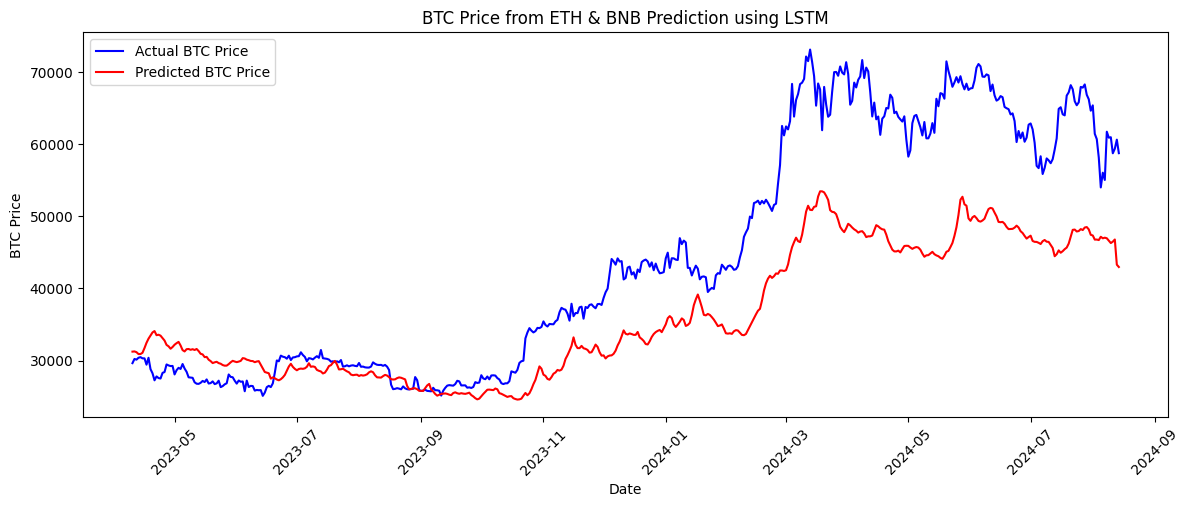

In [12]:
# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values

# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual, color='blue', label='Actual BTC Price')
plt.plot(test_dates, predicted, color='red', label='Predicted BTC Price')
plt.title('BTC Price from ETH & BNB Prediction using LSTM')
plt.xlabel('Date')
plt.ylabel('BTC Price')
plt.xticks(rotation=45) 
plt.legend()
plt.show()


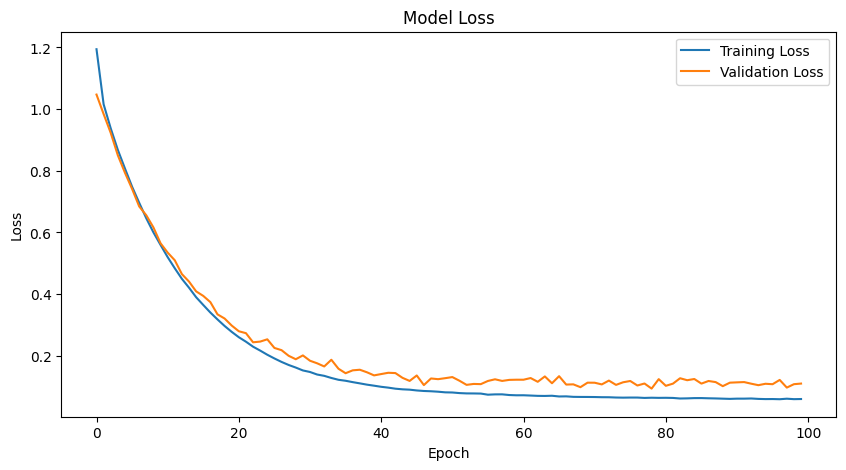

In [13]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

# All features

# BNB from BTC

In [14]:
# Convert the Date column to datetime
for df in [btc_data, bnb_data]:
    df['Date'] = pd.to_datetime(df['Date'])

#Merging the datasets
merged_data =  btc_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'BTC_Open', 'High': 'BTC_High', 'Low': 'BTC_Low', 'Close': 'BTC_Close', 'Volume': 'BTC_Volume'})
merged_data = merged_data.merge(
    bnb_data[['Date', 'Open', 'High', 'Low', 'Close','Volume']].rename(columns={
        'Open': 'BNB_Open', 'High': 'BNB_High', 'Low': 'BNB_Low', 'Close': 'BNB_Close', 'Volume': 'BNB_Volume'}), on='Date')


# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['Date']))

In [15]:
merged_data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,BNB_Open,BNB_High,BNB_Low,BNB_Close,BNB_Volume
0,2017-11-09,7446.830078,7446.830078,7101.520020,7143.580078,3226249984,2.05314,2.17423,1.89394,1.99077,19192200
1,2017-11-10,7173.729980,7312.000000,6436.870117,6618.140137,5208249856,2.00773,2.06947,1.64478,1.79684,11155000
2,2017-11-11,6618.609863,6873.149902,6204.220215,6357.600098,4908680192,1.78628,1.91775,1.61429,1.67047,8178150
3,2017-11-12,6295.450195,6625.049805,5519.009766,5950.069824,8957349888,1.66889,1.67280,1.46256,1.51969,15298700
4,2017-11-13,5938.250000,6811.189941,5844.290039,6559.490234,6263249920,1.52601,1.73502,1.51760,1.68662,12238800


In [16]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-5]  # Use all features except BNB variables
        y = data[i+sequence_length, -2]  # Target is BNB_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7 
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [17]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=32, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)

# metrics
mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 1.0598 - val_loss: 1.1863
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.9596 - val_loss: 1.0360
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.8651 - val_loss: 0.9310
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.7935 - val_loss: 0.8745
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.7403 - val_loss: 0.8207
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.6896 - val_loss: 0.7788
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.6379 - val_loss: 0.7250
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.5913 - val_loss: 0.6921
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.5484 - val_loss: 0.6448
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5110 - val_loss: 0.6123
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.4726 - val_loss: 0.5798
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.

In [19]:
# Create a placeholder for inverse transformation
predicted_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values (only for the BNB_Close column)
predicted_full[:, -2] = predictions[:, 0]
actual_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted = scaler.inverse_transform(predicted_full)[:, -2]
actual = scaler.inverse_transform(actual_full)[:, -2]

# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values

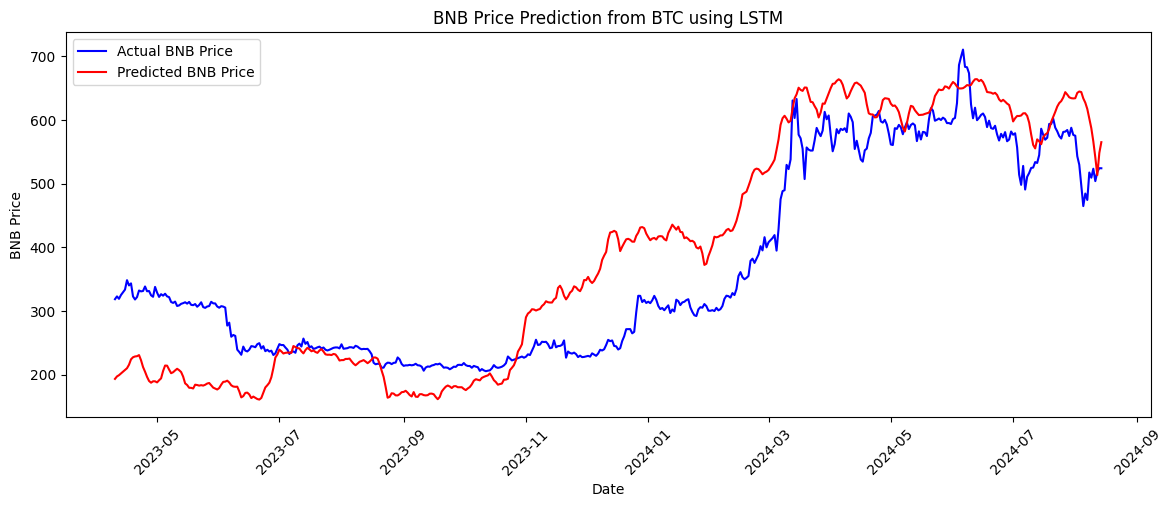

In [20]:
# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual, color='blue', label='Actual BNB Price')
plt.plot(test_dates, predicted, color='red', label='Predicted BNB Price')
plt.title('BNB Price Prediction from BTC using LSTM')
plt.xlabel('Date')
plt.ylabel('BNB Price')
plt.xticks(rotation=45)  # Rotate date labels for better readability
plt.legend()
plt.show()

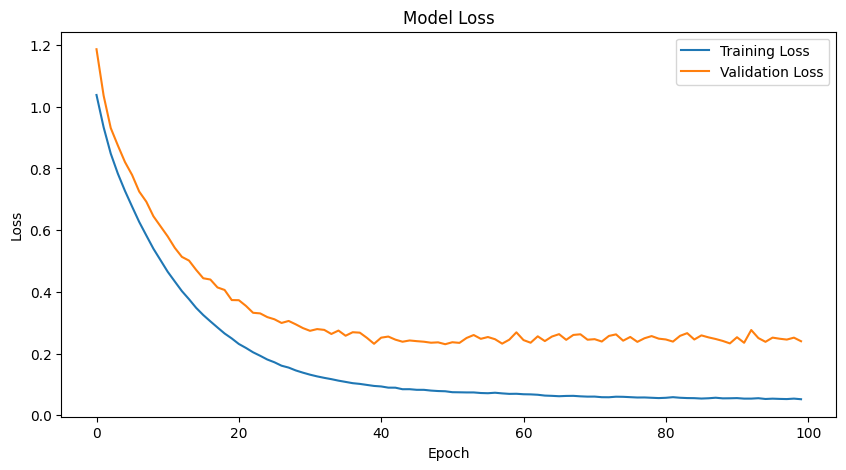

In [21]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

## ETH from BTC

In [3]:
# Convert the Date column to datetime
for df in [btc_data, eth_data]:
    df['Date'] = pd.to_datetime(df['Date'])

#Merging the datasets
merged_data =  btc_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']].rename(columns={
        'Open': 'BTC_Open', 'High': 'BTC_High', 'Low': 'BTC_Low', 'Close': 'BTC_Close', 'Volume': 'BTC_Volume'})
merged_data = merged_data.merge(
    eth_data[['Date', 'Open', 'High', 'Low', 'Close','Volume']].rename(columns={
        'Open': 'ETH_Open', 'High': 'ETH_High', 'Low': 'ETH_Low', 'Close': 'ETH_Close', 'Volume': 'ETH_Volume'}), on='Date')


# Sort the data by the 'Date' column in ascending order
merged_data = merged_data.sort_values(by='Date', ascending=True)

# Drop any rows with missing values
merged_data.dropna(inplace=True)

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(merged_data.drop(columns=['Date']))

In [4]:
merged_data.head()

,Date,BTC_Open,BTC_High,BTC_Low,BTC_Close,BTC_Volume,ETH_Open,ETH_High,ETH_Low,ETH_Close,ETH_Volume
0,2017-11-09,7446.830078,7446.830078,7101.520020,7143.580078,3226249984,308.644989,329.451996,307.056000,320.884003,893249984
1,2017-11-10,7173.729980,7312.000000,6436.870117,6618.140137,5208249856,320.670990,324.717987,294.541992,299.252991,885985984
2,2017-11-11,6618.609863,6873.149902,6204.220215,6357.600098,4908680192,298.585999,319.453003,298.191986,314.681000,842300992
3,2017-11-12,6295.450195,6625.049805,5519.009766,5950.069824,8957349888,314.690002,319.153015,298.513000,307.907990,1613479936
4,2017-11-13,5938.250000,6811.189941,5844.290039,6559.490234,6263249920,307.024994,328.415009,307.024994,316.716003,1041889984


In [5]:
# Prepare the data for time series analysis
def create_sequences(data, sequence_length):
    xs = []
    ys = []
    for i in range(len(data) - sequence_length):
        x = data[i:i+sequence_length, :-5]  # Use all features except ETH variables
        y = data[i+sequence_length, -2]  # Target is ETH_Close
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

sequence_length = 7  
X, y = create_sequences(scaled_data, sequence_length)

# Split the data into training and testing sets
split_ratio = 0.8
split_index = int(split_ratio * len(X))

X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]

In [6]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=64, kernel_regularizer=l2(0.01), return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=32, kernel_regularizer=l2(0.01)))
model.add(Dropout(0.2))
model.add(Dense(units=1))

C:\python312\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_absolute_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2)

# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss}')

# Make predictions
predictions = model.predict(X_test)


mae = mean_absolute_error(y_test, predictions)
print(f'Mean Absolute Error (MAE): {mae}')

mse = mean_squared_error(y_test, predictions)
print(f'Mean Squared Error (MSE): {mse}')

rmse = np.sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 1.0837 - val_loss: 1.0430
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.9473 - val_loss: 0.9174
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.8680 - val_loss: 0.8297
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8012 - val_loss: 0.7742
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.7404 - val_loss: 0.7170
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6894 - val_loss: 0.6607
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.6350 - val_loss: 0.6322
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5929 - val_loss: 0.5851
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.5538 - val_loss: 0.5325
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.5097 - val_loss: 0.5205
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.4770 - val_loss: 0.4854
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step

In [8]:
# Create a placeholder for inverse transformation
predicted_full = np.zeros((predictions.shape[0], scaled_data.shape[1]))
actual_full = np.zeros((y_test.shape[0], scaled_data.shape[1]))

# Fill the placeholder with predicted values (only for the ETH_Close column)
predicted_full[:, -2] = predictions[:, 0]
actual_full[:, -2] = y_test

# Inverse transform to get the original scale
predicted = scaler.inverse_transform(predicted_full)[:, -2]
actual = scaler.inverse_transform(actual_full)[:, -2]

# Create a date range for the test set
test_dates = merged_data['Date'].iloc[split_index + sequence_length:].values

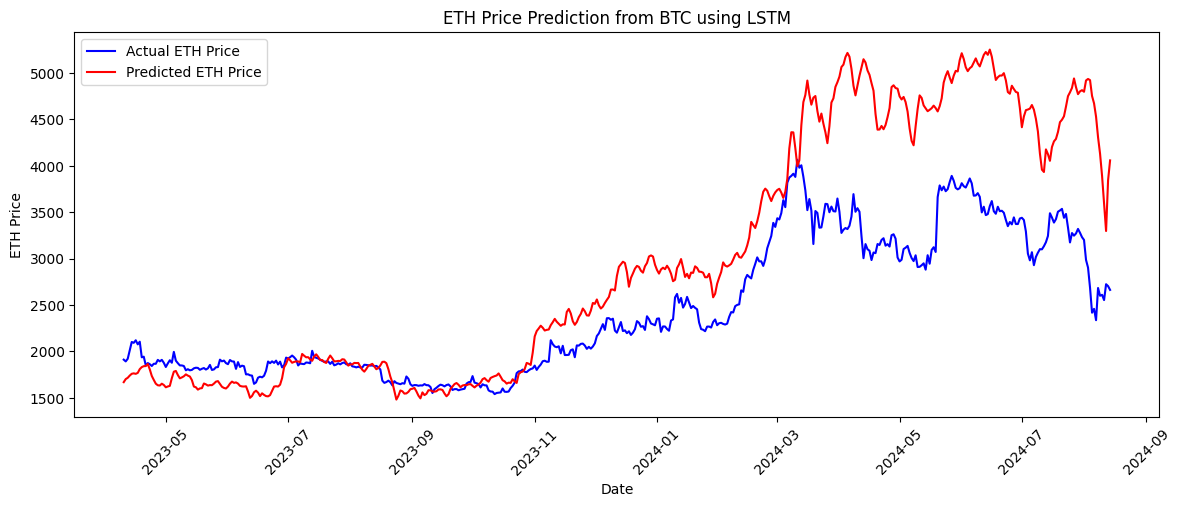

In [9]:
# Plot the results with dates on the x-axis
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual, color='blue', label='Actual ETH Price')
plt.plot(test_dates, predicted, color='red', label='Predicted ETH Price')
plt.title('ETH Price Prediction from BTC using LSTM')
plt.xlabel('Date')
plt.ylabel('ETH Price')
plt.xticks(rotation=45)  
plt.legend()
plt.show()

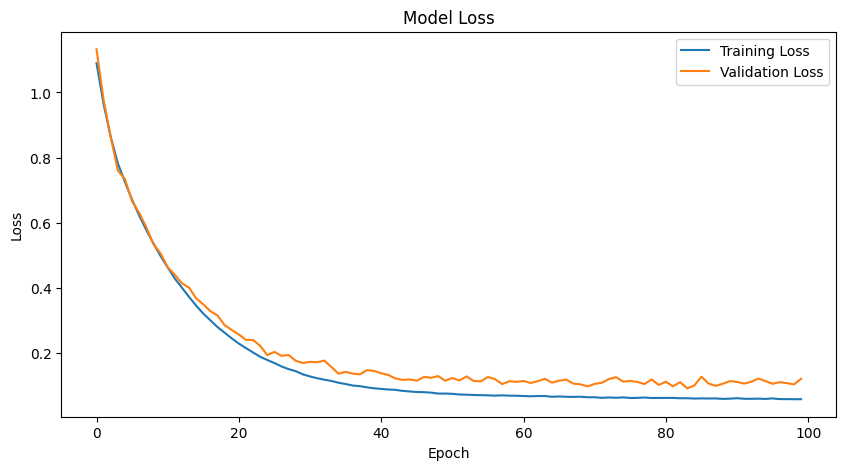

In [29]:
# Plot training & validation loss values
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()